In [29]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
from sparse_wf.model.wave_function import MoonLikeWaveFunction
from sparse_wf.system import get_molecule
from sparse_wf.mcmc import init_electrons

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
molecule_args = {
    'method': 'chain',
    'chain_args': {
        'element': 'H',
        'distance': 1.8,
        'n': 200
    },
    'basis': 'sto-3g'
}
model_args = data = {
    "n_determinants": 16,
    "n_envelopes": 8,
    "embedding": {
        "cutoff": 10.0,
        "feature_dim": 256,
        "nuc_mlp_depth": 4,
        "pair_mlp_widths": [16, 8],
        "pair_n_envelopes": 32
    },
    "jastrow": {
        "e_e_cusps": "psiformer",
        "use_log_jastrow": True,
        "use_mlp_jastrow": True,
        "mlp_depth": 2,
        "mlp_width": 64
    }
}
mol = get_molecule(molecule_args)
wf = MoonLikeWaveFunction.create(mol, **model_args)

In [161]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
electrons = init_electrons(key, mol, 1)[0]
params = wf.init(subkey, electrons)

In [162]:
static = wf.get_static_input(electrons)
logpsi, state = wf.logpsi_with_state(params, electrons, static)

In [163]:
idx = 11
@jax.jit
@jax.vmap
def low_rank(delta):
    inp = electrons.at[idx, 0].add(delta)
    return wf.log_psi_log_rank_update(params, inp, jnp.array([idx]), static, state)[0]

@jax.jit
@jax.vmap
def full_rank(delta):
    inp = electrons.at[idx, 0].add(delta)
    return wf.logpsi_with_state(params, inp, static)[0]

In [174]:
d = jnp.linspace(0, 12, 32)
low_rank_values = low_rank(d)
full_rank_values = full_rank(d)

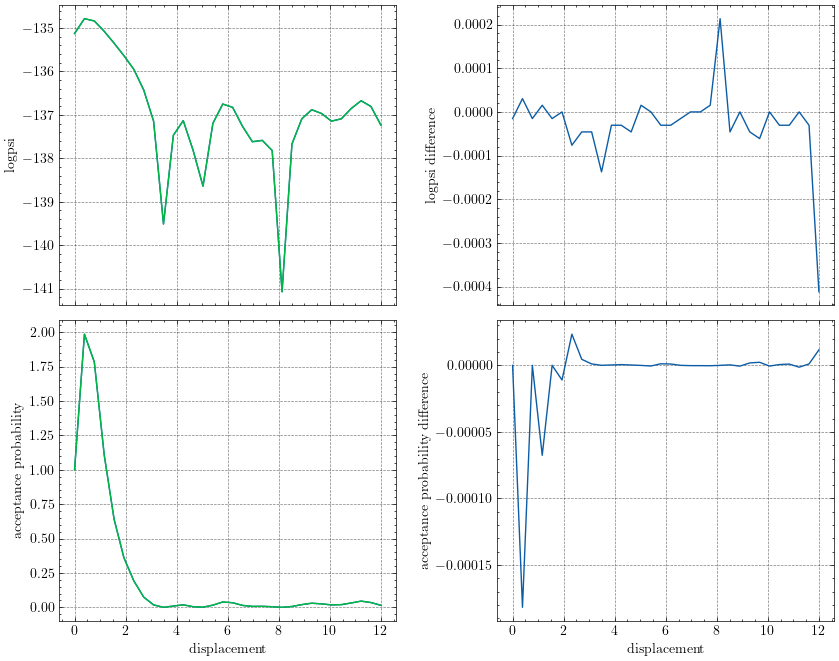

In [175]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
ax1, ax2, ax3, ax4 = axes.ravel()
ax1.plot(d, low_rank_values, label='low rank')
ax1.plot(d, full_rank_values, label='low rank')
ax1.set_ylabel('logpsi')

ax2.plot(d, low_rank_values-full_rank_values)
ax2.set_ylabel('logpsi difference')

full_acc_prob = jnp.exp(2 * (full_rank_values - full_rank_values[0]))
low_acc_prob = jnp.exp(2 * (low_rank_values - low_rank_values[0]))
ax3.plot(d, full_acc_prob, label='full rank')
ax3.plot(d, low_acc_prob, label='low rank')
ax3.set_xlabel('displacement')
ax3.set_ylabel('acceptance probability')

ax4.plot(d, full_acc_prob - low_acc_prob, label='full rank')
ax4.set_xlabel('displacement')
ax4.set_ylabel('acceptance probability difference')

plt.subplots_adjust(wspace=0.3, hspace=0.05)
plt.show()

In [110]:
static

StaticInputMoon(n_deps=NrOfDependencies(h_el_initial=13, H_nuc=26, h_el_out=37), n_neighbours=NrOfNeighbours(ee=13, en=13, ne=13), n_changes=NrOfChanges(h0=16, nuclei=15, out=39))

In [92]:
new_logpsi, new_state = wf.log_psi_log_rank_update(params, electrons + delta, changed_idx, static, state)

In [93]:
real_logpsi, real_state = wf.logpsi_with_state(params, electrons + delta, static)

In [94]:
jax.tree_map(lambda x, y: jnp.linalg.norm(x - y), new_state, real_state)

LowRankState(embedding=MoonState(h_init=Array(5.725775e-06, dtype=float32), h_init_same=Array(4.608208e-06, dtype=float32), h_init_diff=Array(4.3262476e-06, dtype=float32), h0=Array(7.916396, dtype=float32), h1=Array(3.8104386, dtype=float32), HL_up=Array(17.593645, dtype=float32), HL_dn=Array(16.840382, dtype=float32), h_out=Array(3.3669188, dtype=float32)), orbitals=OrbitalState(envelopes=Array(4.350057e-06, dtype=float32), orbitals=Array(2.246044, dtype=float32)), determinant=LogPsiState(matrices=(Array(2.246044, dtype=float32),), inverses=[Array(11578.306, dtype=float32)], slogdets=[(Array(2., dtype=float32), Array(3.996781, dtype=float32))]), jastrow=Array(0.08887396, dtype=float32))

In [95]:
(new_logpsi - real_logpsi), (new_logpsi - real_logpsi) / real_logpsi, real_logpsi, new_logpsi, logpsi

(Array(1.1938934, dtype=float32),
 Array(-0.00869305, dtype=float32),
 Array(-137.33891, dtype=float32),
 Array(-136.14502, dtype=float32),
 Array(-135.126, dtype=float32))

# Benchmarking

In [176]:
electrons = init_electrons(key, mol, 32)

In [170]:
import functools
@functools.partial(jax.jit, static_argnums=1)
@functools.partial(jax.vmap, in_axes=(0, None))
def normal_fwd(electrons, static):
    return wf.logpsi_with_state(params, electrons, static)[0]

In [171]:
static = wf.get_static_input(electrons)
%time jax.block_until_ready(normal_fwd(electrons, static));
%timeit jax.block_until_ready(normal_fwd(electrons, static));

CPU times: user 7.47 s, sys: 314 ms, total: 7.78 s
Wall time: 7.72 s
99.6 ms ± 384 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [172]:
import functools
@functools.partial(jax.jit, static_argnums=1)
@functools.partial(jax.vmap, in_axes=(0, None, 0))
def fast_fwd(electrons, static, state):
    return wf.log_psi_log_rank_update(params, electrons, jnp.array([0]), static, state)

In [177]:
static = wf.get_static_input(electrons)
_, state = jax.vmap(wf.logpsi_with_state, in_axes=(None, 0, None))(params, electrons, static)
%time jax.block_until_ready(fast_fwd(electrons, static, state));
%timeit jax.block_until_ready(fast_fwd(electrons, static, state));

CPU times: user 8.81 s, sys: 194 ms, total: 9 s
Wall time: 10.3 s
9.68 ms ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
normal_fwd(electrons, static) - fast_fwd(electrons, static, state)[0]

Array([-3.0517578e-05, -1.5258789e-05, -1.5258789e-05, -3.0517578e-05,
       -3.0517578e-05,  0.0000000e+00,  1.5258789e-05,  0.0000000e+00,
        7.6293945e-05, -3.0517578e-05,  1.9989014e-03,  0.0000000e+00,
        4.5776367e-05, -1.5258789e-05,  1.5258789e-04,  1.5258789e-05,
        0.0000000e+00, -4.5776367e-05,  0.0000000e+00,  3.0517578e-05,
        7.6293945e-05,  0.0000000e+00,  7.6293945e-06,  0.0000000e+00,
        2.1362305e-04, -1.5258789e-05,  4.5776367e-05,  1.5258789e-05,
        3.6468506e-03,  3.0517578e-05,  1.5258789e-05, -9.9182129e-05],      dtype=float32)